In [2]:
import os
import shutil

In [3]:
my_dataset_path = '../data/cat'
os.mkdir(my_dataset_path)

In [4]:
os.mkdir( os.path.join(my_dataset_path, 'whitecat1') )
os.mkdir( os.path.join(my_dataset_path, 'whitecat2') )
os.mkdir( os.path.join(my_dataset_path, 'whitecat3') )
os.mkdir( os.path.join(my_dataset_path, 'whitecat4') )

In [6]:
pip install gallery-dl

Note: you may need to restart the kernel to use updated packages.


In [7]:
!gallery-dl https://www.pinterest.co.uk/samyii1/animals-white-cats/

./gallery-dl/pinterest/samyii1/Animals …te Cats/pinterest_569142471679806139.jpg
./gallery-dl/pinterest/samyii1/Animals …te Cats/pinterest_569142471679780557.jpg
./gallery-dl/pinterest/samyii1/Animals …te Cats/pinterest_569142471679778632.jpg
./gallery-dl/pinterest/samyii1/Animals …te Cats/pinterest_569142471679770185.jpg
./gallery-dl/pinterest/samyii1/Animals …te Cats/pinterest_569142471679752388.jpg
./gallery-dl/pinterest/samyii1/Animals …te Cats/pinterest_569142471679752355.jpg
./gallery-dl/pinterest/samyii1/Animals …te Cats/pinterest_569142471679752339.jpg
./gallery-dl/pinterest/samyii1/Animals …te Cats/pinterest_569142471679751941.jpg
./gallery-dl/pinterest/samyii1/Animals …te Cats/pinterest_569142471679736620.png
./gallery-dl/pinterest/samyii1/Animals …te Cats/pinterest_569142471679723969.jpg
./gallery-dl/pinterest/samyii1/Animals …te Cats/pinterest_569142471679723962.jpg
./gallery-dl/pinterest/samyii1/Animals …te Cats/pinterest_569142471679723942.jpg
./gallery-dl/pinterest/samyi

In [8]:
source_directory = 'gallery-dl/pinterest/samyii1/Animals -  White Cats' 
class_folder = 'whitecat1'
target_directory = os.path.join(my_dataset_path, class_folder)
    
file_names = os.listdir(source_directory)
    
for file_name in file_names:
    shutil.move(os.path.join(source_directory, file_name), target_directory)

In [9]:
import torch
import torchvision

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

In [10]:
device = 'cpu'
momentum = 0.9
num_epochs = 10
num_classes = 3
val_size = 0.3
batch_size = 100
learn_rate = 0.001
data_path = '../data/cat/'

In [14]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        
        transforms.RandomAffine(degrees=(-30,30),translate=(0.25,0.25),scale=(0.85,1.15)),

        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),

        transforms.RandomResizedCrop(size=(64, 64), antialias=True),

        transforms.ToTensor(),

        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [15]:
val_transform = transforms.Compose(
    [   
        torchvision.transforms.Resize(64, antialias=True),
        torchvision.transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [17]:
train_dataset = ImageFolder(data_path, transform=train_transform)
val_dataset = ImageFolder(data_path, transform=val_transform)

num_train = len(train_dataset)
indices = list(range(num_train))

train_indices, val_indices = train_test_split(indices, test_size=val_size, random_state=42)

train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
val_dataset = torch.utils.data.Subset(val_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

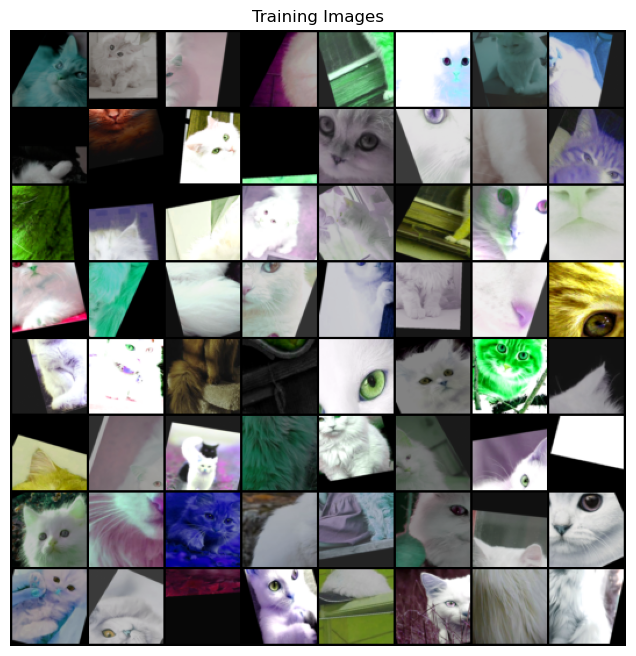

In [18]:
# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [19]:
class ClassificationNetwork(nn.Module):
    def __init__(self):

        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, 5)

        self.conv2 = nn.Conv2d(64, 128, 5)

        self.conv3 = nn.Conv2d(128, 128, 5)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(2048, 256)

        self.fc2 = nn.Linear(256, num_classes)

    #
    def forward(self, x):

        x = F.relu(self.conv1(x))
        
        x = self.pool(x)

        x = F.relu(self.conv2(x))

        x = self.pool(x)

        x = F.relu(self.conv3(x))

        x = self.pool(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))

        x = self.fc2(x)
        
        return x

In [20]:
model = ClassificationNetwork()
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum)

In [21]:
train_losses = []
val_losses = []

best_loss = 100000
for epoch in range(num_epochs): 
    train_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    
    with torch.no_grad():
        val_loss = 0.0
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch + 1}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}')
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model_from_scratch.pt')

Epoch 1, train loss: 1.098, val loss: 1.094
Epoch 2, train loss: 1.093, val loss: 1.084
Epoch 3, train loss: 1.085, val loss: 1.070
Epoch 4, train loss: 1.075, val loss: 1.049
Epoch 5, train loss: 1.060, val loss: 1.013
Epoch 6, train loss: 1.036, val loss: 0.966
Epoch 7, train loss: 1.013, val loss: 0.923
Epoch 8, train loss: 1.011, val loss: 0.897
Epoch 9, train loss: 1.014, val loss: 0.893
Epoch 10, train loss: 1.009, val loss: 0.892


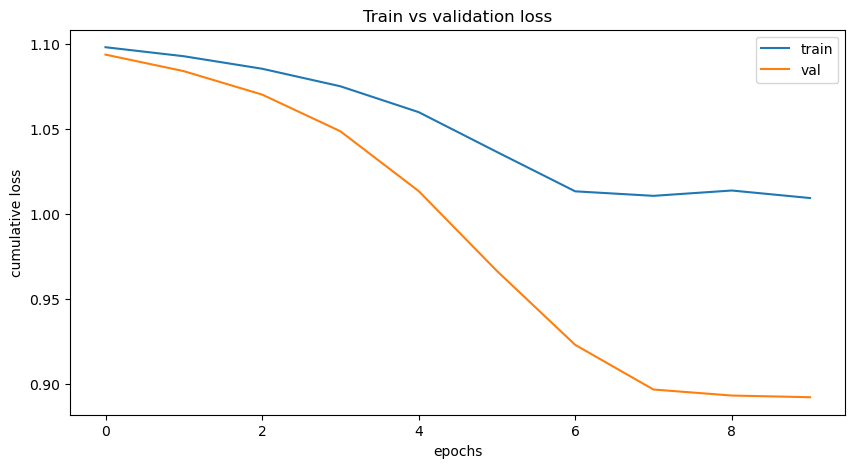

In [22]:
plt.figure(figsize=(10,5))
plt.title("Train vs validation loss")
plt.plot(train_losses,label="train")
plt.plot(val_losses,label="val")
plt.xlabel("epochs")
plt.ylabel("cumulative loss")
plt.legend()
plt.show()

In [23]:
%matplotlib inline

import torch
import torchvision 

import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML
from src.util import weights_init
from src.gan_model import Generator, Discriminator

In [28]:
device = 'cpu'
num_epochs = 40 
batch_size = 128 
image_size = 32 
num_channels = 3 
z_dim = 100 
n_f_maps = 64 
learning_rate = 0.0002 
beta1 = 0.5 

data_path = '../data/cat'

load_chk = False
save_path = 'gan_weights.pt'
load_path = 'gan_weights.pt'

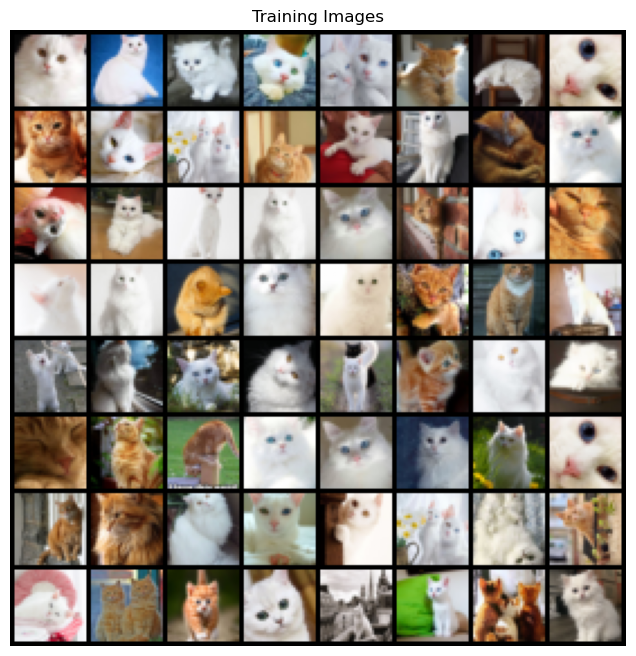

In [29]:
dataset = torchvision.datasets.ImageFolder(root=data_path,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [30]:
discriminator = Discriminator(n_f_maps,num_channels).to(device)
generator = Generator(z_dim,n_f_maps,num_channels).to(device)

if load_chk == True:
    checkpoint_sd = torch.load(load_path, map_location=torch.device('cpu'))
    generator.load_state_dict(checkpoint_sd['generator'])
    discriminator.load_state_dict(checkpoint_sd['discriminator'])
else:
    discriminator.apply(weights_init)
    generator.apply(weights_init)

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

In [31]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    
    for i, data_batch in enumerate(dataloader, 0):
        
        image_data, class_label = data_batch
        image_data = image_data.to(device)
        
        discriminator.zero_grad()
        
        minibatch_size = image_data.size(0)
        label = torch.full((minibatch_size,), real_label, dtype=torch.float, device=device)
        pred_D = discriminator(image_data).squeeze()
        errD_real = criterion(pred_D, label)
        errD_real.backward()
        D_x = pred_D.mean().item()

        noise = torch.randn(minibatch_size, z_dim, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        pred_D = discriminator(fake.detach()).squeeze()
        errD_fake = criterion(pred_D, label)
        errD_fake.backward()
        D_G_z1 = pred_D.mean().item()
        errD = errD_real + errD_fake
        
        optimizerD.step()

        generator.zero_grad()

        noise = torch.randn(minibatch_size, z_dim, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(real_label)  
        pred_D = discriminator(fake).squeeze()
        errG = criterion(pred_D, label)
        errG.backward()
        D_G_z2 = pred_D.mean().item()
        
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x) mean: %.4f\tD(G(z)) mean: %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
            models_dict = {}
            models_dict['generator'] = generator.state_dict()
            models_dict['discriminator'] = discriminator.state_dict()
            torch.save(models_dict, save_path)
            
        iters += 1

[0/40][0/24]	Loss_D: 1.5183	Loss_G: 1.1716	D(x) mean: 0.5508	D(G(z)) mean: 0.4924 / 0.3955
[1/40][0/24]	Loss_D: 0.0386	Loss_G: 4.9176	D(x) mean: 0.9845	D(G(z)) mean: 0.0218 / 0.0149
[2/40][0/24]	Loss_D: 0.0387	Loss_G: 4.7418	D(x) mean: 0.9778	D(G(z)) mean: 0.0113 / 0.0154
[3/40][0/24]	Loss_D: 0.0516	Loss_G: 6.3098	D(x) mean: 0.9874	D(G(z)) mean: 0.0336 / 0.0039
[4/40][0/24]	Loss_D: 0.0360	Loss_G: 5.4423	D(x) mean: 0.9882	D(G(z)) mean: 0.0226 / 0.0099
[5/40][0/24]	Loss_D: 0.1133	Loss_G: 4.6276	D(x) mean: 0.9877	D(G(z)) mean: 0.0888 / 0.0321
[6/40][0/24]	Loss_D: 0.1110	Loss_G: 3.7559	D(x) mean: 0.9355	D(G(z)) mean: 0.0353 / 0.0602
[7/40][0/24]	Loss_D: 0.0784	Loss_G: 5.5487	D(x) mean: 0.9489	D(G(z)) mean: 0.0169 / 0.0089
[8/40][0/24]	Loss_D: 0.4599	Loss_G: 0.7138	D(x) mean: 0.6900	D(G(z)) mean: 0.0275 / 0.5782
[9/40][0/24]	Loss_D: 0.4621	Loss_G: 2.4425	D(x) mean: 0.7432	D(G(z)) mean: 0.0861 / 0.2917
[10/40][0/24]	Loss_D: 1.1059	Loss_G: 5.8607	D(x) mean: 0.8478	D(G(z)) mean: 0.4040 / 0.016

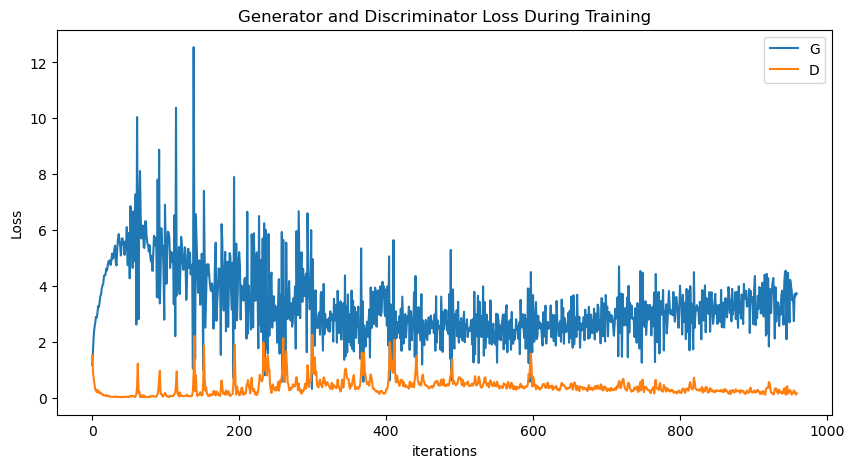

In [32]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

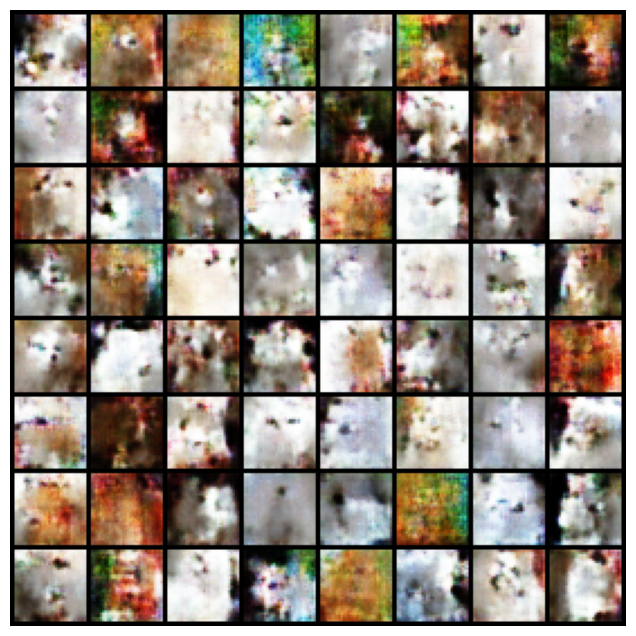

In [33]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

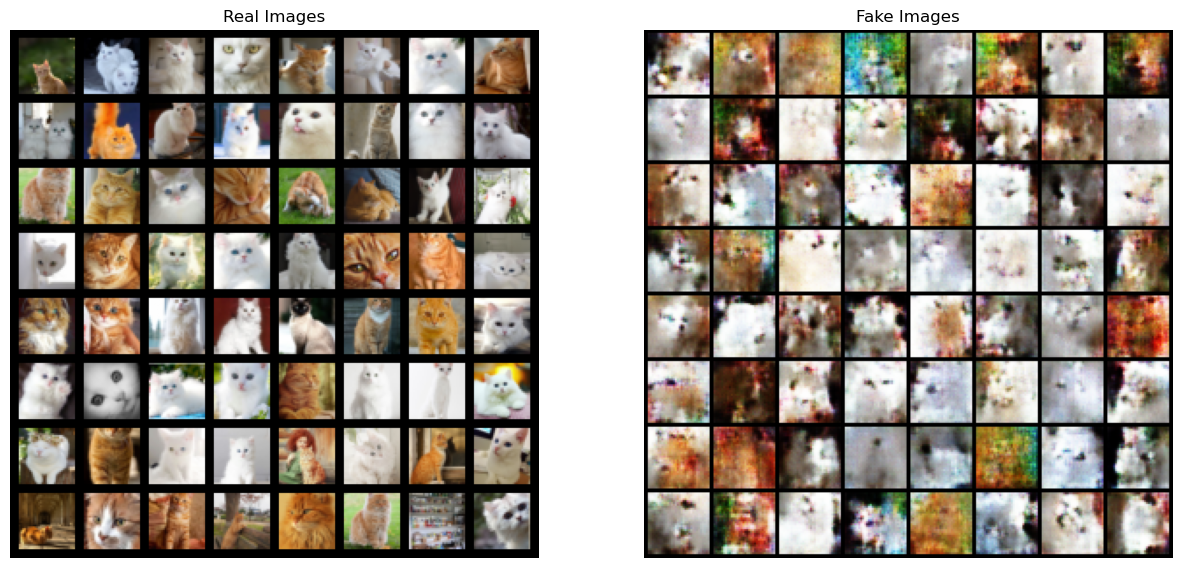

In [34]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()